# Pitch & Roll sequence prediction

In [3]:
import os
import pickle
import random
import matplotlib.pyplot as plt
import matplotlib.colors as pltcolors

# Train results

In [2]:
c = 0
models = []
files = []
results = {}
dir = "training_results"
colors = [name for name, _ in pltcolors.cnames.items()]
random.shuffle(colors)
colors.extend(list("rgbcmyk"))

### Single-step model

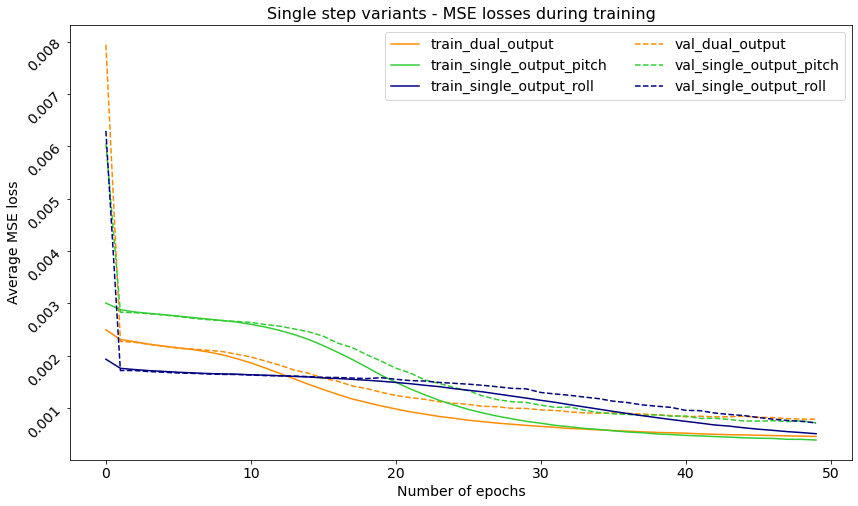

In [13]:
c = 0
font  = 14
models = []
files = []
results = {}
dir = "training_results"
colors = ["darkorange", "limegreen", "navy"]
singlestep = ["LSTM_PR_multi_output", "LSTM_PR_single_output_roll", "LSTM_PR_single_output_pitch"]
colors.extend(list("rgbcmyk"))
plt.figure(figsize=(14, 8))

# build dictionary with same structure as training results folders:
# modelname -> [train loss 1, val loss1, train loss 2, ...]
for model in os.listdir(dir):
    results[model] = []
    for file in os.listdir(dir+"/"+model):
        results[model].append(file)

# sort files in reverse alphabetical order to group them by model parameters
# [train 1, train 2, val 1, val 2] becomes [train 1, val 1, train 2, val 2]     
for model, filenames in results.items():
    if(model in singlestep):
        results[model] = sorted(filenames, key=lambda x: x[::-1])
        for file in results[model]:
            _, _, in_f, out_f, _ = file.split("_")
            if(out_f == "1out" and in_f == "10in"):
                with open(f'{dir}/{model}/{file}', "rb") as f:
                    array = pickle.load(f)
                    modelname = model.split("_")[2:]
                    modelname = "_".join(modelname)
                    if(file[0] == "t"):
                        label = f"train_{modelname}"
                        if(modelname=="multi_output"):
                            label = "train_dual_output"
                        plt.plot(array, label=label, color=colors[c])
                        c += 1
                    else:
                        label = f"val_{modelname}"
                        if(modelname=="multi_output"):
                            label = "val_dual_output"
                        plt.plot(array, label=label, color=colors[c], linestyle='dashed')

plt.ylabel("Average MSE loss", fontsize=font)
plt.xlabel("Number of epochs", fontsize=font)
plt.yticks(fontsize=font, rotation=45)
plt.xticks(fontsize=font)
plt.title("Single step variants - MSE losses during training", fontsize = font+2)
handles, labels = plt.gca().get_legend_handles_labels()
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
plt.legend(handles, labels, ncol=2, fontsize=font)
plt.savefig('../results/training_results/single-step', bbox_inches='tight')
plt.show()

### Encoder-Decoder LSTM

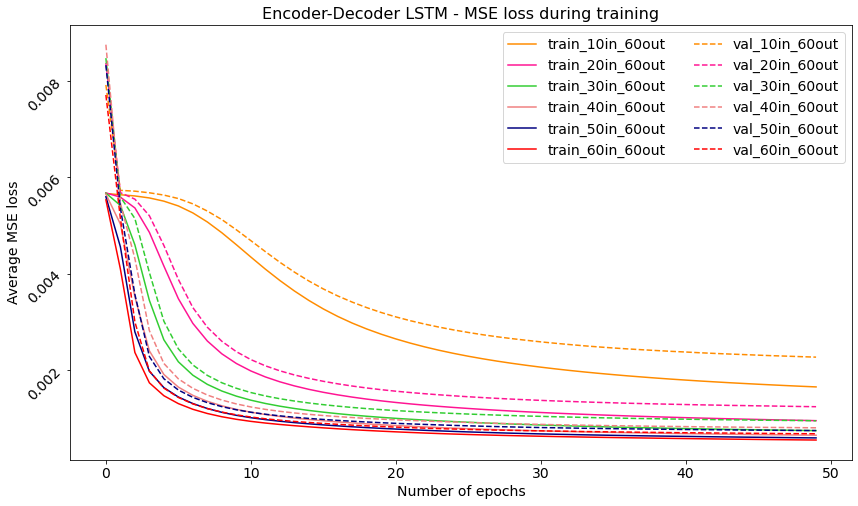

In [4]:
c = 0
font = 14
models = []
files = []
results = {}
dir = "training_results"
colors = ["darkorange", "deeppink", "limegreen", "lightcoral", "navy"]
colors.extend(list("rgbcmyk"))
plt.figure(figsize=(14, 8))

# build dictionary with same structure as training results folders:
# modelname -> [train loss 1, val loss1, train loss 2, ...]
for model in os.listdir(dir):
    results[model] = []
    for file in os.listdir(dir+"/"+model):
        results[model].append(file)

# sort files in reverse alphabetical order to group them by model parameters
# [train 1, train 2, val 1, val 2] becomes [train 1, val 1, train 2, val 2]     
for model, filenames in results.items():
    if(len(model.split("_")) < 3 or model.split("_")[2] != "sequence"):
        continue
    results[model] = sorted(filenames, key=lambda x: x[::-1])
    for file in results[model]:
        _, _, in_f, out_f, _ = file.split("_")
        if(not out_f == "120out"):
            with open(f'{dir}/{model}/{file}', "rb") as f:
                array = pickle.load(f)
                if(file[0] == "t"):
                    label = f"train_{in_f}_{out_f}"
                    plt.plot(array, label=label, color=colors[c])
                    c += 1
                else:
                    label = f"val_{in_f}_{out_f}"
                    plt.plot(array, label=label, color=colors[c], linestyle='dashed')

plt.ylabel("Average MSE loss", fontsize=font)
plt.xlabel("Number of epochs", fontsize=font)
plt.yticks(fontsize=font, rotation=45)
plt.xticks(fontsize=font)
handles, labels = plt.gca().get_legend_handles_labels()
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
plt.legend(handles, labels, ncol=2, fontsize=font)
plt.title("Encoder-Decoder LSTM - MSE loss during training", fontsize=font+2)
plt.savefig('../results/training_results/lstm-sequence', bbox_inches='tight')
plt.show()

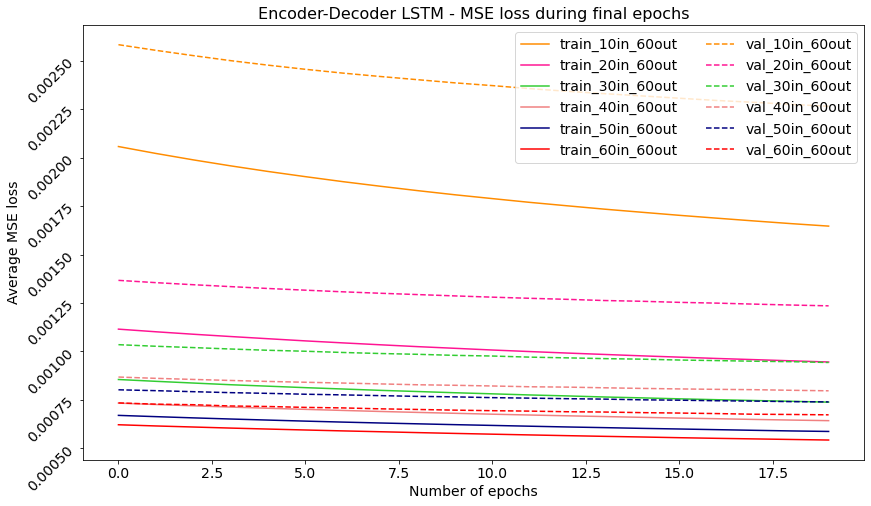

In [8]:
c = 0
font = 14
models = []
files = []
results = {}
dir = "training_results"
colors = ["darkorange", "deeppink", "limegreen", "lightcoral", "navy"]
colors.extend(list("rgbcmyk"))
plt.figure(figsize=(14, 8))

# build dictionary with same structure as training results folders:
# modelname -> [train loss 1, val loss1, train loss 2, ...]
for model in os.listdir(dir):
    results[model] = []
    for file in os.listdir(dir+"/"+model):
        results[model].append(file)

# sort files in reverse alphabetical order to group them by model parameters
# [train 1, train 2, val 1, val 2] becomes [train 1, val 1, train 2, val 2]     
for model, filenames in results.items():
    if(len(model.split("_")) < 3 or model.split("_")[2] != "sequence"):
        continue
    results[model] = sorted(filenames, key=lambda x: x[::-1])
    for file in results[model]:
        _, _, in_f, out_f, _ = file.split("_")
        if(not out_f == "120out"):
            with open(f'{dir}/{model}/{file}', "rb") as f:
                array = pickle.load(f)
                if(file[0] == "t"):
                    label = f"train_{in_f}_{out_f}"
                    plt.plot(array[-20:], label=label, color=colors[c])
                    c += 1
                else:
                    label = f"val_{in_f}_{out_f}"
                    plt.plot(array[-20:], label=label, color=colors[c], linestyle='dashed')

plt.ylabel("Average MSE loss", fontsize=font)
plt.xlabel("Number of epochs", fontsize=font)
plt.yticks(fontsize=font, rotation=45)
plt.xticks(fontsize=font)
handles, labels = plt.gca().get_legend_handles_labels()
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
plt.legend(handles, labels, ncol=2, fontsize=font)
plt.title("Encoder-Decoder LSTM - MSE loss during final epochs", fontsize=font+2)
plt.savefig('../results/training_results/lstm-sequence_end', bbox_inches='tight')
plt.show()

### Sequential CNN

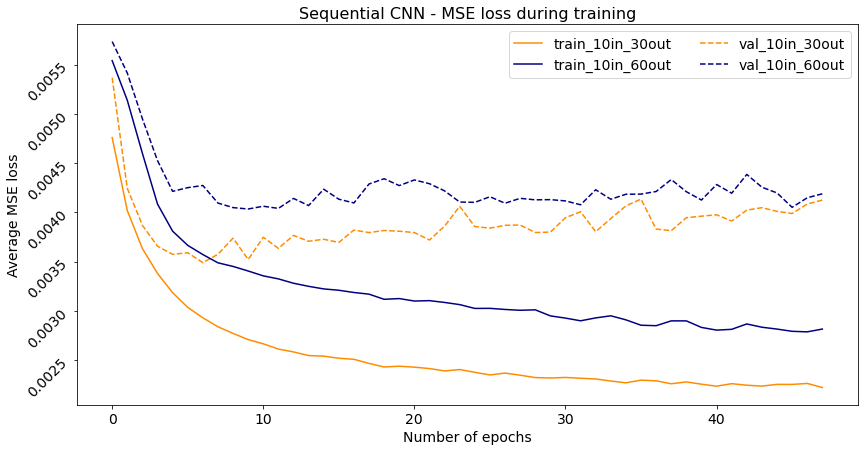

In [16]:
c = 0
font = 14
models = []
files = []
results = {}
dir = "training_results"
colors = ["darkorange", "navy", "limegreen", "deeppink",  "grey"]
colors.extend(list("rgbcmyk"))
plt.figure(figsize=(14, 7))

# build dictionary with same structure as training results folders:
# modelname -> [train loss 1, val loss1, train loss 2, ...]
for model in os.listdir(dir):
    results[model] = []
    for file in os.listdir(dir+"/"+model):
        results[model].append(file)

# sort files in reverse alphabetical order to group them by model parameters
# [train 1, train 2, val 1, val 2] becomes [train 1, val 1, train 2, val 2]     
for model, filenames in results.items():
    if(model.split("_")[1] != "linear"):
        continue
    results[model] = sorted(filenames, key=lambda x: x[::-1])
    for file in results[model]:
        type, _, in_f, out_f, _ = file.split("_")
        with open(f'{dir}/{model}/{file}', "rb") as f:
            array = pickle.load(f)
            if(file[0] == "t"):
                label = f"{type}_{in_f}_{out_f}"
                plt.plot(array[2:], label=label, color=colors[c])
                c += 1
            else:
                label = f"{type}_{in_f}_{out_f}"
                plt.plot(array[2:], label=label, color=colors[c], linestyle='dashed')

plt.ylabel("Average MSE loss", fontsize=font)
plt.xlabel("Number of epochs", fontsize=font)
plt.yticks(fontsize=font, rotation=45)
plt.xticks(fontsize=font)
plt.title("Sequential CNN - MSE loss during training", fontsize=font+2)
handles, labels = plt.gca().get_legend_handles_labels()
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
plt.legend(handles, labels, ncol=2, fontsize=font)
plt.savefig('../results/training_results/seq_cnn', bbox_inches='tight')
plt.show()

### CNN LSTM single input

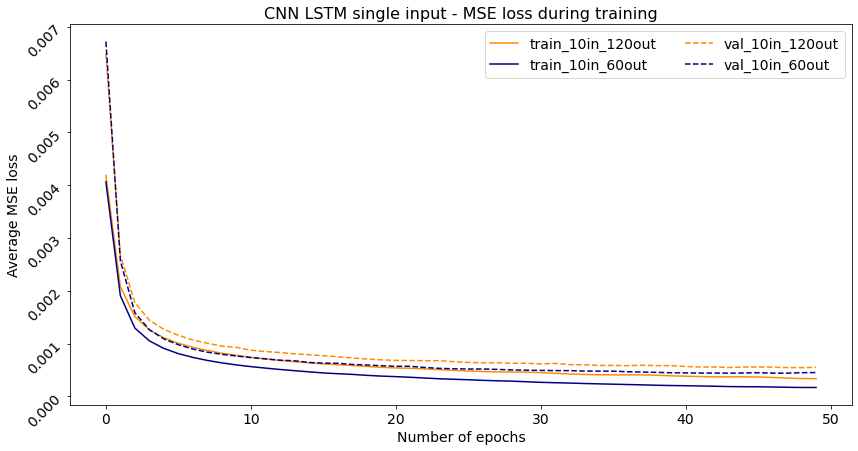

In [112]:
c = 0
font = 14
models = []
files = []
results = {}
dir = "training_results"
colors = ["darkorange", "navy", "limegreen", "deeppink",  "grey"]
colors.extend(list("rgbcmyk"))
plt.figure(figsize=(14, 7))

# build dictionary with same structure as training results folders:
# modelname -> [train loss 1, val loss1, train loss 2, ...]
for model in os.listdir(dir):
    results[model] = []
    for file in os.listdir(dir+"/"+model):
        results[model].append(file)

# sort files in reverse alphabetical order to group them by model parameters
# [train 1, train 2, val 1, val 2] becomes [train 1, val 1, train 2, val 2]     
for model, filenames in results.items():
    if(model.split("_")[1] != "img-to-PR"):
        continue
    results[model] = sorted(filenames, key=lambda x: x[::-1])
    for file in results[model]:
        type, _, in_f, out_f, _ = file.split("_")
        with open(f'{dir}/{model}/{file}', "rb") as f:
            array = pickle.load(f)
            if(file[0] == "t"):
                label = f"{type}_{in_f}_{out_f}"
                plt.plot(array, label=label, color=colors[c])
                c += 1
            else:
                label = f"{type}_{in_f}_{out_f}"
                plt.plot(array, label=label, color=colors[c], linestyle='dashed')

plt.ylabel("Average MSE loss", fontsize=font)
plt.xlabel("Number of epochs", fontsize=font)
plt.yticks(fontsize=font, rotation=45)
plt.xticks(fontsize=font)
plt.title("CNN LSTM single input - MSE loss during training", fontsize=font+2)
handles, labels = plt.gca().get_legend_handles_labels()
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
plt.legend(handles, labels, ncol=2, fontsize=font)
plt.savefig('../results/training_results/cnn', bbox_inches='tight')
plt.show()

### Parameter testing

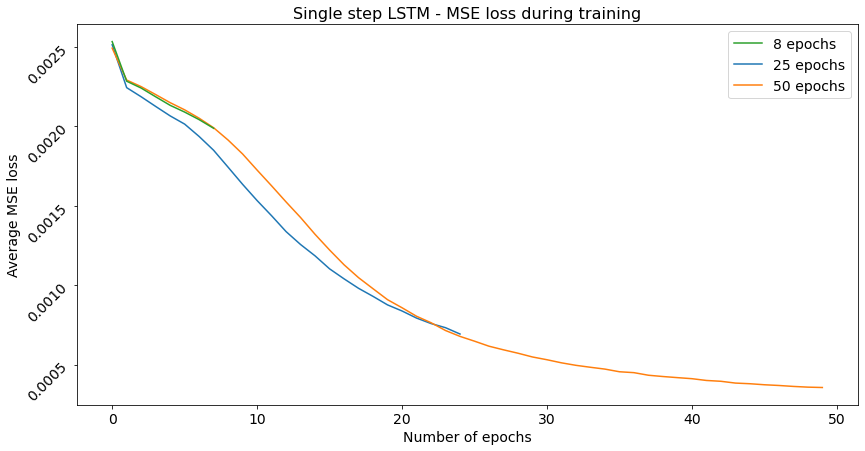

In [111]:
c = 0
font = 14
models = []
files = []
results = {}
dir = "training_results/test_LSTM_PR_multi_output"
colors = ["darkorange", "limegreen", "navy"]
colors.extend(list("rgbcmyk"))
plt.figure(figsize=(14, 7))

# build dictionary with same structure as training results folders:
# modelname -> [train loss 1, val loss1, train loss 2, ...]
for file in os.listdir(dir):
    type, _, inf, outf, epochs, lr, hid = file.split("_")
    if(type == "train" and lr == f"{0.001}lr" and hid == f"{128}hidden"):
        with open(f'{dir}/{file}', 'rb') as f:
            array = pickle.load(f)
            plt.plot(array, label = f"{epochs[:-6]} epochs")

plt.ylabel("Average MSE loss", fontsize=font)
plt.xlabel("Number of epochs", fontsize=font)
plt.yticks(fontsize=font, rotation=45)
plt.xticks(fontsize=font)
plt.title("Single step LSTM - MSE loss during training", fontsize=font+2)
handles, labels = plt.gca().get_legend_handles_labels()
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: int(t[0][0:2])))
plt.legend(handles, labels, fontsize=font)
plt.savefig('../results/training_results/epoch_tests', bbox_inches='tight')
plt.show()

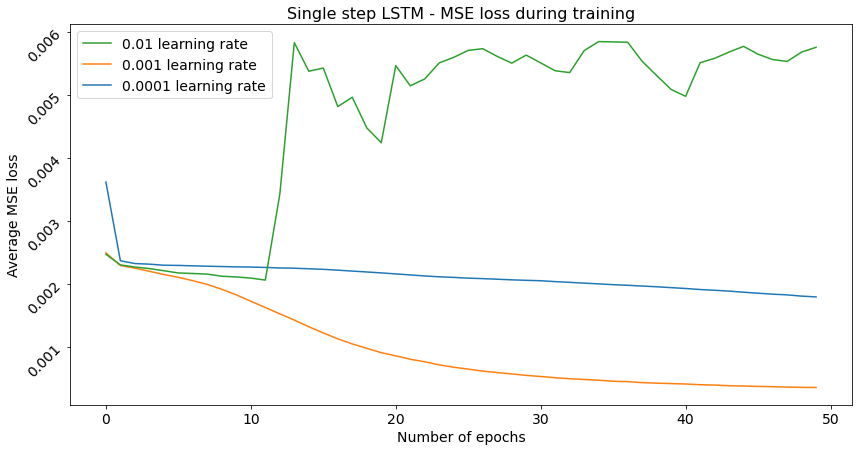

In [110]:
c = 0
font = 14
models = []
files = []
results = {}
dir = "training_results/test_LSTM_PR_multi_output"
colors = ["darkorange", "limegreen", "navy"]
colors.extend(list("rgbcmyk"))
plt.figure(figsize=(14, 7))

# build dictionary with same structure as training results folders:
# modelname -> [train loss 1, val loss1, train loss 2, ...]
for file in os.listdir(dir):
    type, _, inf, outf, epochs, lr, hid = file.split("_")
    if(type == "train" and epochs == f"{50}epochs" and hid == f"{128}hidden"):
        with open(f'{dir}/{file}', 'rb') as f:
            array = pickle.load(f)
            plt.plot(array, label = f"{lr[:-2]} learning rate")

plt.ylabel("Average MSE loss", fontsize=font)
plt.xlabel("Number of epochs", fontsize=font)
plt.yticks(fontsize=font, rotation=45)
plt.xticks(fontsize=font)
plt.title("Single step LSTM - MSE loss during training", fontsize=font+2)
handles, labels = plt.gca().get_legend_handles_labels()
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0], reverse=True))
plt.legend(handles, labels, fontsize=font)
plt.savefig('../results/training_results/lr_tests', bbox_inches='tight')
plt.show()

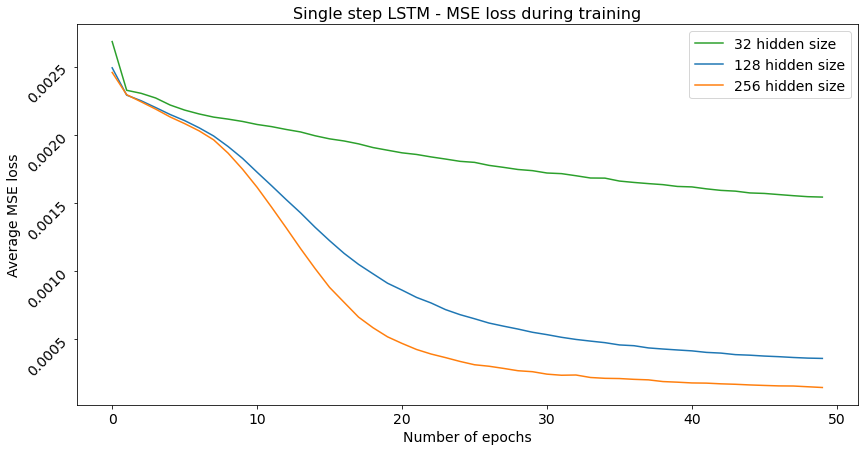

In [109]:
c = 0
font = 14
models = []
files = []
results = {}
dir = "training_results/test_LSTM_PR_multi_output"
colors = ["darkorange", "limegreen", "navy"]
colors.extend(list("rgbcmyk"))
plt.figure(figsize=(14, 7))

# build dictionary with same structure as training results folders:
# modelname -> [train loss 1, val loss1, train loss 2, ...]
for file in os.listdir(dir):
    type, _, inf, outf, epochs, lr, hid = file.split("_")
    if(type == "train" and epochs == f"{50}epochs" and lr == f"{0.001}lr"):
        with open(f'{dir}/{file}', 'rb') as f:
            array = pickle.load(f)
            plt.plot(array, label = f"{hid[:-6]} hidden size")

plt.ylabel("Average MSE loss", fontsize=font)
plt.xlabel("Number of epochs", fontsize=font)
plt.yticks(fontsize=font, rotation=45)
plt.xticks(fontsize=font)
plt.title("Single step LSTM - MSE loss during training", fontsize=font+2)
handles, labels = plt.gca().get_legend_handles_labels()
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: int(t[0][0:3])))
plt.legend(handles, labels, fontsize=font)
plt.savefig('../results/training_results/hidden_tests', bbox_inches='tight')
plt.show()